In [15]:
from google.colab import drive
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Montar Google Drive
drive.mount('/content/drive')


project_path = "/content/drive/My Drive/Colab Notebooks/Proyecto"

# Cargar el diccionario JSON
with open(os.path.join(project_path, 'id_to_target.json'), 'r') as f:
    subfolder_to_target = json.load(f)

# Las transformaciones : redimensionar y normalizar
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
class ImageDataset(Dataset):
    def __init__(self, image_folder, subfolder_to_target, transform=None):
        self.image_folder = image_folder
        self.subfolder_to_target = subfolder_to_target
        self.transform = transform
        self.image_paths = []
        self.targets = []

        #  asociar imágenes con etiquetas
        for root, dirs, files in os.walk(image_folder):
            subfolder_name = os.path.basename(root)
            target = self.subfolder_to_target.get(subfolder_name, None)
            if target is not None:
                for file_name in files:
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        file_path = os.path.join(root, file_name)
                        self.image_paths.append(file_path)
                        self.targets.append(target)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target = self.targets[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)

# Crear el Dataset con las transformaciones
image_folder_path = os.path.join(project_path, "extracted_files")
custom_dataset = ImageDataset(image_folder_path, subfolder_to_target, transform=image_transforms)

# Crear el DataLoader
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Verificar el DataLoader
for batch_idx, (images, targets) in enumerate(dataloader):
    print(f"Lote {batch_idx + 1}: Imágenes {images.shape}, Targets {targets.shape}")
    if batch_idx == 1:
        break

# Cargar el modelo preentrenado ResNet50
model_name = "microsoft/resnet-50"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

# Mover al GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Congelar todas las capas excepto la última
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para regresión
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)

# Mover al GPU
model = model.to(device)

# El optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Dividir el dataset en entrenamiento,  validación y prueba
dataset_size = len(custom_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Crear DataLoaders para cada split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ver los tamaños de los splits
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lote 1: Imágenes torch.Size([32, 3, 224, 224]), Targets torch.Size([32])
Lote 2: Imágenes torch.Size([32, 3, 224, 224]), Targets torch.Size([32])
Tamaño del dataset de entrenamiento: 1193
Tamaño del dataset de validación: 149
Tamaño del dataset de prueba: 150


Epoch [1/50], Pérdida Entrenamiento: 0.5142
Pérdida Validación: 0.5189
Precisión Entrenamiento: 0.6829, Precisión Validación: 0.6821
Epoch [2/50], Pérdida Entrenamiento: 0.4709
Pérdida Validación: 0.4730
Precisión Entrenamiento: 0.6656, Precisión Validación: 0.6648
Epoch [3/50], Pérdida Entrenamiento: 0.4405
Pérdida Validación: 0.4425
Precisión Entrenamiento: 0.6507, Precisión Validación: 0.6495
Epoch [4/50], Pérdida Entrenamiento: 0.4235
Pérdida Validación: 0.4238
Precisión Entrenamiento: 0.6380, Precisión Validación: 0.6365
Epoch [5/50], Pérdida Entrenamiento: 0.3916
Pérdida Validación: 0.4075
Precisión Entrenamiento: 0.6245, Precisión Validación: 0.6253
Epoch [6/50], Pérdida Entrenamiento: 0.3781
Pérdida Validación: 0.3878
Precisión Entrenamiento: 0.6132, Precisión Validación: 0.6137
Epoch [7/50], Pérdida Entrenamiento: 0.3600
Pérdida Validación: 0.3795
Precisión Entrenamiento: 0.6019, Precisión Validación: 0.6036
Epoch [8/50], Pérdida Entrenamiento: 0.3539
Pérdida Validación: 0.369

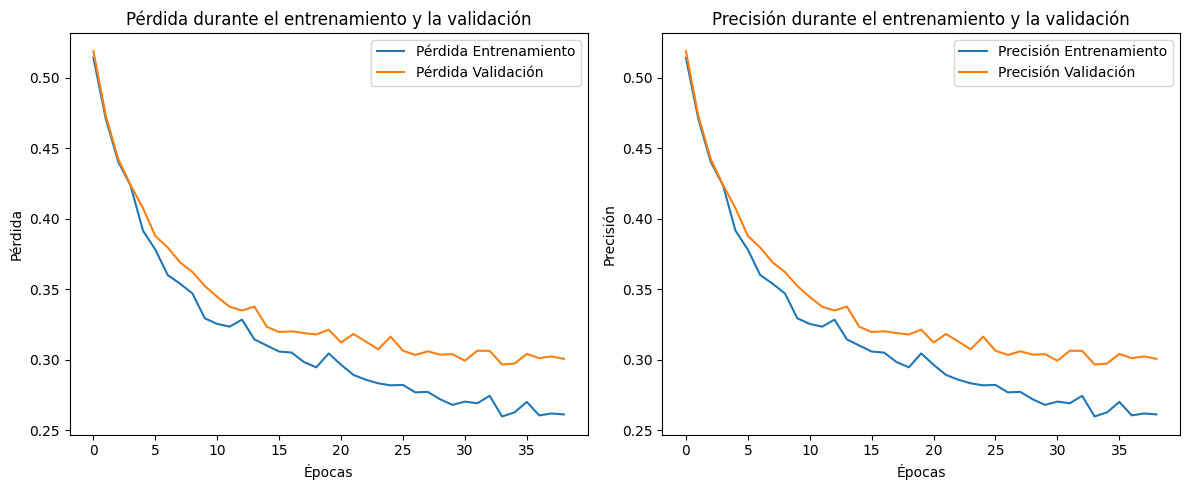

In [16]:

# Guardar las salidas, los targets y las perdidas
train_outputs = []
train_targets = []
val_outputs = []
val_targets = []
train_losses = []
val_losses = []

#  Early stopping
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# Función de precisión
def calculate_accuracy(preds, targets):
    abs_error = torch.abs(preds - targets)
    return abs_error.mean().item()

# Entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(images).logits
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Guardar salidas y targets
        train_outputs.append(outputs.squeeze().cpu().detach().numpy())
        train_targets.append(targets.cpu().detach().numpy())

    #  guardar la pérdida media
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Pérdida Entrenamiento: {epoch_train_loss:.4f}")

    #  validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images).logits
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

            # Guardar salidas y targets para validación
            val_outputs.append(outputs.squeeze().cpu().detach().numpy())
            val_targets.append(targets.cpu().detach().numpy())

    # guardar la pérdida de validación
    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Pérdida Validación: {epoch_val_loss:.4f}")

    # Calcular precisión
    train_accuracy = calculate_accuracy(torch.tensor(np.concatenate(train_outputs)), torch.tensor(np.concatenate(train_targets)))
    val_accuracy = calculate_accuracy(torch.tensor(np.concatenate(val_outputs)), torch.tensor(np.concatenate(val_targets)))
    print(f"Precisión Entrenamiento: {train_accuracy:.4f}, Precisión Validación: {val_accuracy:.4f}")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Detención temprana, no hubo mejora en {patience} épocas.")
        break

torch.save({'train_outputs': train_outputs, 'train_targets': train_targets}, '/content/drive/My Drive/Colab Notebooks/Proyecto/train_outputs_targets_T.pth')
torch.save({'val_outputs': val_outputs, 'val_targets': val_targets}, '/content/drive/My Drive/Colab Notebooks/Proyecto/val_outputs_targets_T.pth')

# Guardar el modelo entrenado
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/Proyecto/best_model_T.pth')
print("Modelo guardado.")


#Graficos:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Pérdida Entrenamiento")
plt.plot(val_losses, label="Pérdida Validación")
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Precisión Entrenamiento")
plt.plot(val_losses, label="Precisión Validación")
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Evaluación con test
test_outputs = []
test_targets = []

model.eval()
test_loss = 0.0


with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images).logits.squeeze()
        targets = targets.squeeze()
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Guardar las salidas y targets
        test_outputs.append(outputs.cpu().detach().numpy())
        test_targets.append(targets.cpu().detach().numpy())

# la pérdida media del test
average_test_loss = test_loss / len(test_loader)
print(f"Pérdida de Test: {average_test_loss:.4f}")

# Aplanar las salidas y los targets
test_outputs_flat = np.concatenate([output.flatten() for output in test_outputs])
test_targets_flat = np.concatenate([target.flatten() for target in test_targets])

# Guardar los resultados
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/test_outputs.npy', test_outputs_flat)
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/test_targets.npy', test_targets_flat)

# Calcular precisión de test
test_accuracy = calculate_accuracy(torch.tensor(test_outputs_flat), torch.tensor(test_targets_flat))
print(f"Precisión en Test: {test_accuracy:.4f}")


Pérdida de Test: 0.3028
Precisión en Test: 0.4354
